Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Pchelintsev Ilya"
COLLABORATORS = "BPM192"

---

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

# Уравнение теплопроводности

Начально-краевая задача для уравнения теплопроводности с постоянным коэффициентом в общем виде можно записать следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} + f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника. 

## Явная схема

Запишем разностное уравнение явной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} + f_i^k,$$
где $\tau$ и $h$ - шаги по времени и пространству, $y_i^k$ - значение приближённого решения в точке $(i, k)$ сетки, $y_i^k$ - значение функции источника в той же точке сетки. 

Аппроксимируем начальное и граничные условия:
$$
\begin{array}{l}
y_i^0 = u_0(x_i), \; \forall i = \overline{0, N},\\
y_0^k = \mu_1(t_k), \\
y_N^k = \mu_2(t_k), \; \forall k > 0.
\end{array}$$

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Обратите внимание, что 
$$\exists \lim\limits_{t \rightarrow \infty} u(x, t) = u_\infty (x).$$
поэтому расчёт в какой-то момент следует остановить (считать до установления).

Во время проведения расчетов помните о том, что явная схема *условно* устойчива.

In [4]:
def heat_expl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with an explicit scheme.
    
    Parameters
    ----------
    init : callable
       Initial condition
    bound1 : callable
       Boundary condition for x = 0
    bound1 : callable
       Boundary condition for x = lx
    alpha : float
       Thermal diffusivity
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between 
       solution on this time step and the next is less the tol.
       
    Returns
    -------
    t_end : float
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    
    # YOUR CODE HERE
    w_x = np.arange(0, lx+h, h)[:int(lx/h)+1]
    t_0 = 0.
    
    t_end = t_0 + tau
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    for i in range(1, len(u_end)-1):
        u_end[i] = u_0[i] + tau * alpha / (h ** 2) * (u_0[i+1] - 2 * u_0[i] + u_0[i-1])
    
    while np.linalg.norm(u_end - u_0) >= tol:
        u_0 = u_end.copy()
        t_end += tau
        u_end[0] = bound1(t_end)
        u_end[-1] = bound2(t_end)
        for i in range(1, len(u_end)-1):
            u_end[i] = u_0[i] + tau * alpha / (h ** 2) * (u_0[i+1] - 2 * u_0[i] + u_0[i-1])
    
    
    
    return t_end, u_end

Протестируйте Вашу функцию.

In [5]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_expl(lambda x: 0., lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005) 
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. Для этого для каждой переменной ($t$ или $x$):

1. Сделайте несколько расчётов для разных значений шага (например, $h_0, \; 2 h_0, \; 4 h_0$).
2. В один и тот же момент времени $t_1$ найдите ошибку полученных решений. Для этого либо возьмите аналитическое решение задачи, либо сравните результат в конечный момент времени, например, с решением в момент времени $0.99 t_1$. Обратите внимание, что имеющуюся функцию `heat_expl` надо немного модифицировать.
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной.

In [6]:
def heat_expl_history(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    w_x = np.arange(0, lx+h, h)[:int(lx/h)+1]
    t_0 = 0.
    
    ts = []
    errs = []
    
    t_end = t_0 + tau
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    for i in range(1, len(u_end)-1):
        u_end[i] = u_0[i] + tau * alpha / (h ** 2) * (u_0[i+1] - 2 * u_0[i] + u_0[i-1])
        
    while np.linalg.norm(u_end - u_0) >= tol:
        ts.append(t_end)
        errs.append(np.linalg.norm(u_end - u_0))
        u_0 = u_end.copy()
        t_end += tau
        u_end[0] = bound1(t_end)
        u_end[-1] = bound2(t_end)
        for i in range(1, len(u_end)-1):
            u_end[i] = u_0[i] + tau * alpha / (h ** 2) * (u_0[i+1] - 2 * u_0[i] + u_0[i-1])
    
    return t_end, u_end, ts, errs

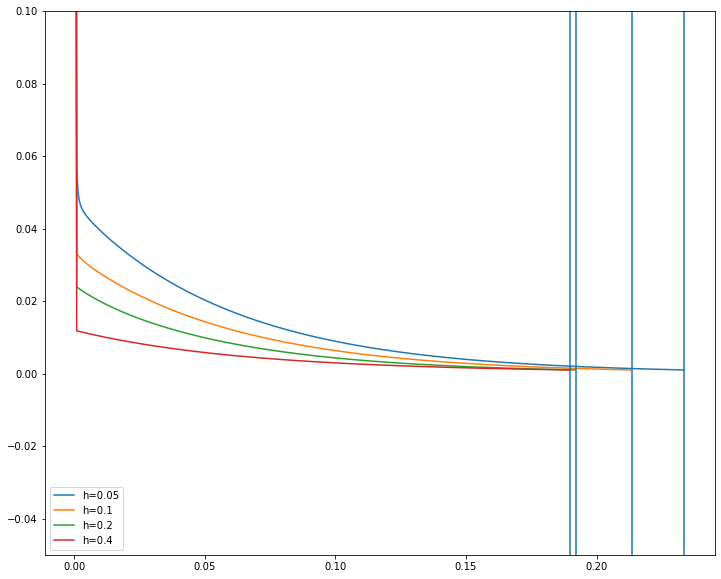

In [21]:
hs = [0.05, 0.1, 0.2, 0.4]
plt.figure(figsize=(12,10))
for h0 in hs:
    t_1, u_1, ts1, errs1 = heat_expl_history(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=h0, tau=0.0005) 
    plt.plot(ts1, errs1, label=f'h={h0}')
    plt.axvline(ts1[-1])
plt.legend()
plt.ylim(-0.05, 0.1)
plt.savefig('expl_t1.png')

подходит t1 = 0.15

In [9]:
def heat_expl_t1_err(init, bound1, bound2, alpha, lx, h, tau, t1, real_u, tol=1e-3):
    w_x = np.arange(0, lx+h, h)[:int(lx/h)+1]
    t_0 = 0.
    not_made=True
    t1_err=0.
    t_end = t_0 + tau
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    u_end = np.zeros(u_0.shape)
    
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    for i in range(1, len(u_end)-1):
        u_end[i] = u_0[i] + tau * alpha / (h ** 2) * (u_0[i+1] - 2 * u_0[i] + u_0[i-1])
        
    
    while np.linalg.norm(u_end - u_0) >= tol:
        u_0 = u_end.copy()
        t_end += tau
        u_end[0] = bound1(t_end)
        u_end[-1] = bound2(t_end)
        for i in range(1, len(u_end)-1):
            u_end[i] = u_0[i] + tau * alpha / (h ** 2) * (u_0[i+1] - 2 * u_0[i] + u_0[i-1])
        
        if t_end > t1 and not_made:
            u_t1 = u_end.copy()
            u_real = real_u(w_x, t_end)
            t1_err = np.linalg.norm(u_t1 - u_real) / (int(lx/h)+1)
            not_made = False
            
    
    return t_end, u_end, t1_err

def heat_analytic_1():
    pass

def heat_analytic_2(x, t):
    return np.sin(4*x) * np.exp(-16 * t)
# https://ru.wikipedia.org/wiki/%D0%A3%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%82%D0%B5%D0%BF%D0%BB%D0%BE%D0%BF%D1%80%D0%BE%D0%B2%D0%BE%D0%B4%D0%BD%D0%BE%D1%81%D1%82%D0%B8

h=0.05: err=0.0013514809420432546
h=0.1: err=0.0018249990882053255
h=0.2: err=0.008702518877112708
h=0.4: err=0.02864961517653961


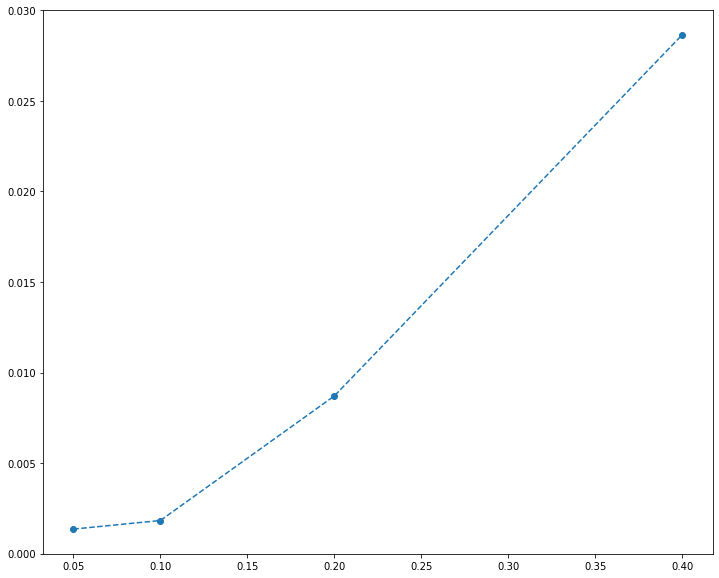

In [10]:
hs = np.array([0.05, 0.1, 0.2, 0.4])
t1 = 0.15
errs = []
plt.figure(figsize=(12,10))
for h0 in hs:
    t_1, u_1, err = heat_expl_t1_err(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=h0, tau=0.0005, t1=t1, real_u=heat_analytic_2) 
    errs.append(err)
plt.plot(hs, errs, 'o--')
for i in range(len(hs)):
    print(f'h={hs[i]}: err={errs[i]}')
plt.savefig('expl_err.png')

## Неявная схема 

Запишем разностное уравнение неявной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2} + f_i^{k+1}.$$

Аппроксимировать начальное и граничные условия будем так же, как в случае явной схемы.

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Для решения системы линейных уравнений используйте встроенные функции `scipy`.

In [11]:
from scipy.linalg import solve_banded

def heat_impl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    """ Solve heat equation u_t = a*u_xx for x in (0; lx) with implicit scheme
    
    Parameters
    ----------
    init : callable
       Initial condition
    bound1 : callable
       Boundary condition for x = 0
    bound1 : callable
       Boundary condition for x = lx
    alpha : float, optional
       Thermal diffusivity
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between 
       solution on this time step and the next is less the tol.
       
    Returns
    -------
    t_end : float
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    
    w_x = np.arange(0, lx+h, h)[:int(lx/h)+1]
    t_0 = 0.
    t_end = t_0 + tau
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    N = u_0.shape[0]
    
    A = np.zeros((N-2,N-2), dtype=np.float64)
    b = np.zeros(N-2, dtype=np.float64)
    u_end = np.zeros(N, dtype=np.float64)
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    
    A[0][:2] = (2 * alpha * tau / np.power(h, 2) + 1), -(alpha * tau / np.power(h, 2))
    b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
    for i in range(1,N-3):
        A[i][i-1], A[i][i], A[i][i+1] = -(alpha * tau / np.power(h, 2)), (2 * alpha * tau / np.power(h, 2) + 1), -(alpha * tau / np.power(h, 2))
        b[i] = u_0[i+1]
    A[-1][-2:] = -(alpha * tau / np.power(h, 2)), (2 * alpha * tau / np.power(h, 2) + 1)
    b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
    ab = np.zeros((3, A.shape[0]))
    ab[0,1:] = np.diag(A,k=1)
    ab[1] = np.diag(A)
    ab[2,:-1] = np.diag(A, k=-1)
    u_end[1:-1] = solve_banded((1,1),ab,b) 
    while np.linalg.norm(u_end - u_0) >= tol:
        u_0 = u_end.copy()
        t_end += tau
        
        u_end = np.zeros(N, dtype=np.float64)
        u_end[0] = bound1(t_end)
        u_end[-1] = bound2(t_end)
        
        b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
        for i in range(1,N-3):
            b[i] = u_0[i+1]
        b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
        
        u_end[1:-1] = solve_banded((1,1),ab,b)   
        
    u_0 = u_end.copy()
    t_end += tau
    u_end = np.zeros(N, dtype=np.float64)
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
    for i in range(1,N-3):
        b[i] = u_0[i+1]
    b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
    u_end[1:-1] = solve_banded((1,1),ab,b) 
    
    return t_end, u_end

Протестируйте Вашу функцию.

In [12]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_impl(lambda x: 0., lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005) 
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. (см. выше)

In [13]:
def heat_impl_history(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):        
    w_x = np.arange(0, lx+h, h)[:int(lx/h)+1]
    t_0 = 0.
    ts=[]
    errs=[]
    t_end = t_0 + tau
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    N = u_0.shape[0]
    
    A = np.zeros((N-2,N-2), dtype=np.float64)
    b = np.zeros(N-2, dtype=np.float64)
    u_end = np.zeros(N, dtype=np.float64)
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    
    A[0][:2] = (2 * alpha * tau / np.power(h, 2) + 1), -(alpha * tau / np.power(h, 2))
    b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
    for i in range(1,N-3):
        A[i][i-1], A[i][i], A[i][i+1] = -(alpha * tau / np.power(h, 2)), (2 * alpha * tau / np.power(h, 2) + 1), -(alpha * tau / np.power(h, 2))
        b[i] = u_0[i+1]
    A[-1][-2:] = -(alpha * tau / np.power(h, 2)), (2 * alpha * tau / np.power(h, 2) + 1)
    b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
    ab = np.zeros((3, A.shape[0]))
    ab[0,1:] = np.diag(A,k=1)
    ab[1] = np.diag(A)
    ab[2,:-1] = np.diag(A, k=-1)
    u_end[1:-1] = solve_banded((1,1),ab,b) 
    
    while np.linalg.norm(u_end - u_0) >= tol:
        ts.append(t_end)
        errs.append(np.linalg.norm(u_end - u_0))
        u_0 = u_end.copy()
        t_end += tau
        
        u_end = np.zeros(N, dtype=np.float64)
        u_end[0] = bound1(t_end)
        u_end[-1] = bound2(t_end)
        
        b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
        for i in range(1,N-3):
            b[i] = u_0[i+1]
        b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
        
        u_end[1:-1] = solve_banded((1,1),ab,b)   
        
    u_0 = u_end.copy()
    t_end += tau
    u_end = np.zeros(N, dtype=np.float64)
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
    for i in range(1,N-3):
        b[i] = u_0[i+1]
    b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
    u_end[1:-1] = solve_banded((1,1),ab,b) 
    
    return t_end, u_end, ts, errs

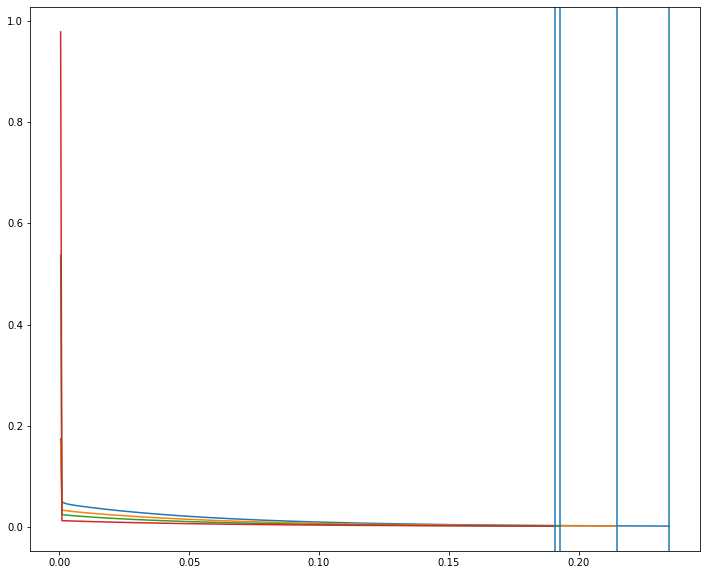

In [14]:
hs = [0.05, 0.1, 0.2, 0.4]
plt.figure(figsize=(12,10))
for h0 in hs:
    t_1, u_1, ts1, errs1 = heat_impl_history(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=h0, tau=0.0005) 
    plt.plot(ts1, errs1, label=f'h={h0}')
    plt.axvline(ts1[-1])
plt.legend()
plt.savefig('impl_t1.png')

Подходит t1=0.15

In [15]:
def heat_impl_t1_err(init, bound1, bound2, alpha, lx, h, tau, t1, real_u, tol=1e-3):
    w_x = np.arange(0, lx+h, h)[:int(lx/h)+1]
    t_0 = 0.
    t1_err = 0.
    not_made=True
    t_end = t_0 + tau
    u_0 = np.array([init(x) for x in w_x], dtype=np.float64)
    N = u_0.shape[0]
    
    A = np.zeros((N-2,N-2), dtype=np.float64)
    b = np.zeros(N-2, dtype=np.float64)
    u_end = np.zeros(N, dtype=np.float64)
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    
    A[0][:2] = (2 * alpha * tau / np.power(h, 2) + 1), -(alpha * tau / np.power(h, 2))
    b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
    for i in range(1,N-3):
        A[i][i-1], A[i][i], A[i][i+1] = -(alpha * tau / np.power(h, 2)), (2 * alpha * tau / np.power(h, 2) + 1), -(alpha * tau / np.power(h, 2))
        b[i] = u_0[i+1]
    A[-1][-2:] = -(alpha * tau / np.power(h, 2)), (2 * alpha * tau / np.power(h, 2) + 1)
    b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
    ab = np.zeros((3, A.shape[0]))
    ab[0,1:] = np.diag(A,k=1)
    ab[1] = np.diag(A)
    ab[2,:-1] = np.diag(A, k=-1)
    u_end[1:-1] = solve_banded((1,1),ab,b) 
    
    while np.linalg.norm(u_end - u_0) >= tol:
        u_0 = u_end.copy()
        t_end += tau
        
        u_end = np.zeros(N, dtype=np.float64)
        u_end[0] = bound1(t_end)
        u_end[-1] = bound2(t_end)
        
        b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
        for i in range(1,N-3):
            b[i] = u_0[i+1]
        b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
        
        u_end[1:-1] = solve_banded((1,1),ab,b)   
        
        if t_end > t1 and not_made:
            u_t1 = u_end.copy()
            u_real = real_u(w_x, t_end)
            t1_err = np.linalg.norm(u_t1 - u_real) / (int(lx/h)+1)
            not_made = False
        
    u_0 = u_end.copy()
    t_end += tau
    u_end = np.zeros(N, dtype=np.float64)
    u_end[0] = bound1(t_end)
    u_end[-1] = bound2(t_end)
    b[0] = u_0[1] + (alpha * tau / np.power(h, 2)) * u_end[0]
    for i in range(1,N-3):
        b[i] = u_0[i+1]
    b[-1] = u_0[-2] + (alpha * tau / np.power(h, 2)) * u_end[-1]
    u_end[1:-1] = solve_banded((1,1),ab,b) 
    
    return t_end, u_end, t1_err

def heat_analytic_1():
    pass

def heat_analytic_2(x, t):
    return np.sin(4*x) * np.exp(-16 * t)

h=0.0125: err=6.343227525685949e-05
h=0.025: err=0.00036215391996912403
h=0.05: err=0.0013103705070489666
h=0.1: err=0.0017977086477119382
h=0.2: err=0.008733215270347788
h=0.4: err=0.028911274971574284


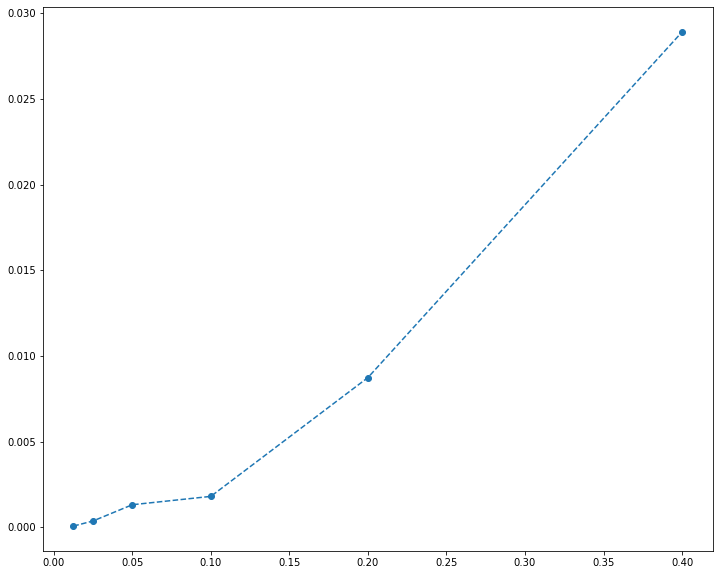

In [16]:
hs = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.4])
t1 = 0.15
errs = []
plt.figure(figsize=(12,10))
for h0 in hs:
    t_1, u_1, err = heat_impl_t1_err(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=h0, tau=0.0005, t1=t1, real_u=heat_analytic_2) 
    errs.append(err)
plt.plot(hs, errs, 'o--')
for i in range(len(hs)):
    print(f'h={hs[i]}: err={errs[i]}')
plt.savefig('impl_err.png')